# Atividade - Reservatórios Equivalentes de Energia


### Eduardo Mendes Loureiro



## Imports

#### Instalar as bibliotecas

Descomentar e rodar caso necessário

In [28]:
## PySDDP

# !pip install PySDDP=='0.0.34'


## Faz o link com a sua conta do Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

#### Realizar os imports necessários

*   Classe Newave do PySDDP: Realiza a leitura do deck do modelo Newave e encapsula todas as informações em um único objeto
*   Importa a biblioteca Numpy com o "apelido" np
* Importa as classes gráficas matplotlib e plotly

In [29]:
from PySDDP.Pen import Newave
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


## Leitura do deck do PMO



Realiza a leitura de um deck do pmo;

Adaptar a variável caminho conforme a pasta em que o deck estiver.

In [30]:
# Caminho = '/content/drive/MyDrive/NewaveJan2021'

Caminho = './NW202308_UNSI_ACL'

Caso = Newave(Caminho)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


## Funções p/ calcular EarMax e ENA 

 - Energia Armazenada Máxima (EarMax) 

 - Energia Natural Afluente (ENA)

In [31]:
def calc_EarMax(confhd, codigo_ree):
    nanos = len(confhd._status_vol_morto['valor'][0])
    earmax = np.zeros((nanos, 12), 'f')
    for iusi in confhd.lista_uhes():
        uhe = confhd.get(iusi)
        if uhe['vol_util'] > 0 and uhe['ree'] == codigo_ree:
            for iano in range(nanos):
                for imes in range(12):
                    if uhe['status_vol_morto'][iano][imes] == 2:
                        earmax[iano][imes] +=  uhe['ro_acum'][iano][imes] * uhe['vol_util'] / 2.63
    return earmax

def calc_ENA(confhd, codigo_ree):

    nanos = len(confhd._status_vol_morto['valor'][0])

    nanos_hist = len(confhd._vazoes['valor'][0])

    ec = np.zeros((nanos, 12, nanos_hist), 'f')
    ena = np.zeros((nanos, 12, nanos_hist), 'f')

    for iusi, ree in enumerate(confhd._ree['valor']):
        if ree == codigo_ree:
            codigo = confhd._codigo['valor'][iusi]
            for iano in range(nanos):
                for imes in range(12):
                    if confhd._status_vol_morto['valor'][iusi][iano][imes] == 2:
                        if confhd._vol_util['valor'][iusi] > 0:
                            ec[iano][imes] += confhd._ro_acum_med['valor'][iusi][iano][imes] * confhd.vaz_inc_entre_res(codigo, iano, imes)
                        for ianoh in range(nanos_hist):
                            ena[iano][imes][ianoh] += confhd._ro_65['valor'][iusi][iano][imes] * confhd._vazoes['valor'][iusi][ianoh][imes]
    efio = ena - ec
    return [ena, ec, efio]

## Programa Principal

Calcular EarMax e ENA para cada REE

In [32]:
# inicializar variáveis
REEs = list(range(1,13))

earMax = np.zeros((len(REEs), 1), 'f')

nanos = len(Caso.confhd._status_vol_morto['valor'][0])
nanos_hist = len(Caso.confhd._vazoes['valor'][0])
ec = np.zeros((len(REEs),nanos, 12, nanos_hist), 'f')
efio = np.zeros((len(REEs),nanos, 12, nanos_hist), 'f')
ena = np.zeros((len(REEs),nanos, 12, nanos_hist), 'f')


# calcular earMax, ena, ec, efio para cada REE
for i, ree in enumerate(REEs):
    earMax[i] = calc_EarMax(Caso.confhd, ree)[0][0]
    [ena[i], ec[i], efio[i]] = calc_ENA(Caso.confhd, ree)


## Resultados - dataframes

EarMax p/ cada REE (valor único)

In [33]:
df_earMax = pd.DataFrame(earMax, index=REEs, columns=['EarMax (MWmed))'])
df_earMax.index.name = 'REE'
df_earMax

,EarMax (MWmed))
REE,
1,50990.910156
2,10145.283203
3,51714.679688
4,14380.893555
5,0.000000
6,313.701691
7,914.307068
8,28.106716
9,785.951233


Shapes de ENA, EC e Efio p/ cada REE

In [34]:
df_shapes = pd.DataFrame([list(np.shape(ena)),
                           list(np.shape(ec)),
                           list(np.shape(efio))], index=['ENA', 'EC', 'Efio'], columns=['REEs', 'Anos estudo', 'Meses', 'Anos hist.'])

df_shapes

,REEs,Anos estudo,Meses,Anos hist.
ENA,12,5,12,93
EC,12,5,12,93
Efio,12,5,12,93


## Resultados - Plots

### Funções

In [37]:
def plota_ena_bruta(ENAs, num_ree):

    ena = ENAs[num_ree - 1]

    num_anos = len(ena)
    num_mes = len(ena[0])
    num_series = len(ena[0][0])

    x_axis = np.arange(1, num_anos*num_mes+1)

    media = np.zeros(num_anos * num_mes)
    for iserie in range(num_series - 1):
        ena_bruta = np.zeros(60)
        indice = 0
        for iano in range(num_anos):
            for imes in range(num_mes):
                ena_bruta[indice] = ena[iano][imes][iserie]
                indice += 1
        media = media + ena_bruta

        plt.plot(x_axis, ena_bruta, 'c-')

    media = media / (num_series - 1)
    plt.plot(x_axis, media, 'r-', lw=3)

    desvio = np.zeros(num_anos * num_mes)
    indice = 0
    for iano in range(num_anos):
        for imes in range(num_mes):
            desvio[indice] = np.nanstd(ena[:][iano][imes])
            indice += 1
    plt.plot(x_axis, media + desvio, 'r-.', lw=2)
    plt.plot(x_axis, media - desvio, 'r-.', lw=2)
    titulo = 'Energia Natural Afluente Bruta do REE ' + str(num_ree)
    plt.title(titulo, fontsize=16)
    plt.xlabel('Mês de Estudo', fontsize=16)
    plt.ylabel('MWMes', fontsize=16)
    plt.show()



def plota_ec(ECs, num_ree):

    ec = ECs[num_ree - 1]
    
    num_anos = len(ec)
    num_mes = len(ec[0])
    num_series = len(ec[0][0])

    x_axis = np.arange(1, num_anos*num_mes+1)

    media = np.zeros(num_anos * num_mes)
    for iserie in range(num_series - 1):
        EC = np.zeros(60)
        indice = 0
        for iano in range(num_anos):
            for imes in range(num_mes):
                EC[indice] = ec[iano][imes][iserie]
                indice += 1
        media = media + EC

        plt.plot(x_axis, EC, 'c-')

    media = media / (num_series - 1)
    plt.plot(x_axis, media, 'r-', lw=3)

    desvio = np.zeros(num_anos * num_mes)
    indice = 0
    for iano in range(num_anos):
        for imes in range(num_mes):
            desvio[indice] = np.nanstd(ec[:][iano][imes])
            indice += 1
    plt.plot(x_axis, media + desvio, 'r-.', lw=2)
    plt.plot(x_axis, media - desvio, 'r-.', lw=2)
    titulo = 'Energia Controlavel do REE ' + str(num_ree)
    plt.title(titulo, fontsize=16)
    plt.xlabel('Mês de Estudo', fontsize=16)
    plt.ylabel('MWMes', fontsize=16)
    plt.show()



def plota_efio_bruta(Efios, num_ree):

    efio = Efios[num_ree - 1]

    num_anos = len(efio)
    num_mes = len(efio[0])
    num_series = len(efio[0][0])

    x_axis = np.arange(1, num_anos*num_mes+1)

    media = np.zeros(num_anos * num_mes)
    for iserie in range(num_series - 1):
        efio_bruta = np.zeros(60)
        indice = 0
        for iano in range(num_anos):
            for imes in range(num_mes):
                efio_bruta[indice] = efio[iano][imes][iserie]
                indice += 1
        media = media + efio_bruta

        plt.plot(x_axis, efio_bruta, 'c-')

    media = media / (num_series - 1)
    plt.plot(x_axis, media, 'r-', lw=3)

    desvio = np.zeros(num_anos * num_mes)
    indice = 0
    for iano in range(num_anos):
        for imes in range(num_mes):
            desvio[indice] = np.nanstd(efio[:][iano][imes])
            indice += 1
    plt.plot(x_axis, media + desvio, 'r-.', lw=2)
    plt.plot(x_axis, media - desvio, 'r-.', lw=2)
    titulo = "Energia Fio D'Agua Bruta do REE " + str(num_ree)
    plt.title(titulo, fontsize=16)
    plt.xlabel('Mês de Estudo', fontsize=16)
    plt.ylabel('MWmes', fontsize=16)
    plt.show()
    

### Exibição

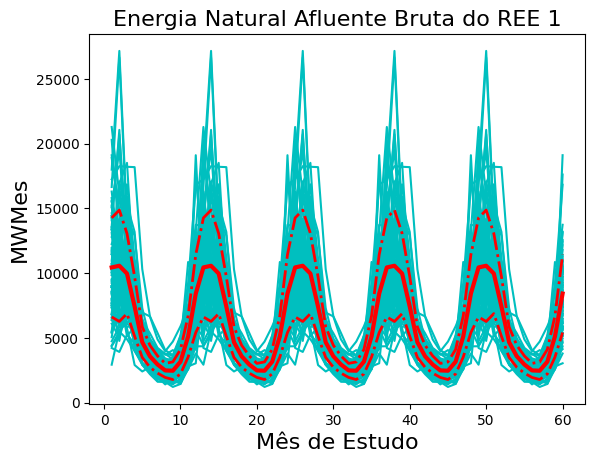

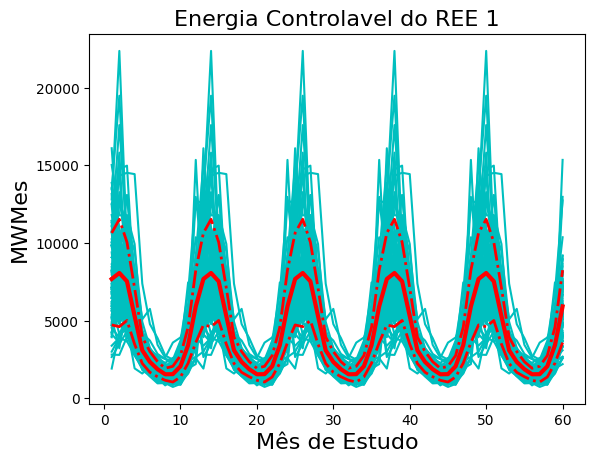

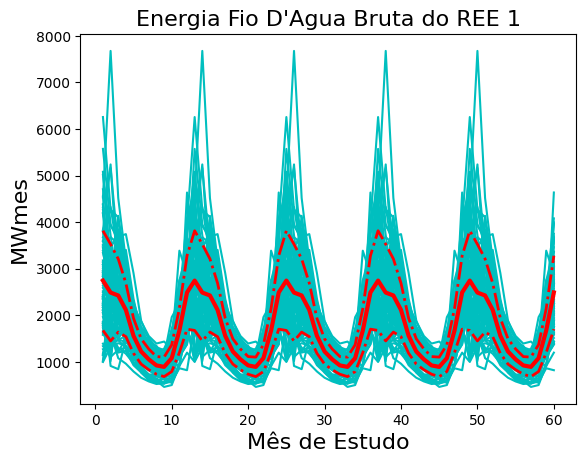

In [38]:
# lista_REEs_plot = range(1,13)
lista_REEs_plot = [1]

for i in lista_REEs_plot:
    plota_ena_bruta(ena, i)
    plota_ec(ec, i)
    plota_efio_bruta(efio, i)
    